In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import sys
import re, string
import nltk, spacy, gensim
from scipy.stats.mstats import gmean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, fbeta_score 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.pipeline import FeatureUnion, Pipeline 


from numpy import dot
from numpy.linalg import norm
import pickle

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/amyphillip/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
def load_data(data_splits):
    """
    Function that combines the DataFrame for training, validation, and test.
    """
    path = "dataset/archive/disaster_response_messages_{}.csv"
    dfs = []
    for data_split in data_splits:
        file_path = path.format(data_split)
        dfs.append(pd.read_csv(file_path))
    return pd.concat(dfs) #combine files for each split

In [4]:
def data_cleaning(data_df):
    """
    Function that cleans the data.
    """    
    data_df = data_df.drop_duplicates()
    return data_df 

In [5]:
def save_to_database(data_df,db_name):
    """
    Save data to database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Write dataframe to database
    data_df.to_sql('data_df',engine,if_exists='replace')
    pass 

In [6]:
def load_from_database(db_name):
    """
    Load data from database for further analysis.
    """    
    engine = create_engine("sqlite:///{}".format(db_name))
    # Read dataframe from database
    data_df = pd.read_sql_table('data_df',engine)
    data_df = data_df.dropna(subset=["message"])
    X = data_df['message'].fillna(value='')
    C = data_df.iloc[:,4:]
    message_class = C.columns
    return X, C, message_class

In [7]:
def document_cleaning(data_df):
    """
    Function that cleans the document.
    """    

    data = data_df.values.tolist()                            # convert data to list
    data = [re.sub(r'\S*@\S*\s?', '', item) for item in data] # Remove email addresses
    data = [re.sub('[%s]' % re.escape(string.punctuation), ' ', item) for item in data] # Remove punctuations
    data = [re.sub(r'\s+', ' ', item) for item in data]       # Remove characters that begin a new line
    data = [re.sub(r"\'", "", item) for item in data]         # Remove single quotes
    data = [re.sub(r'\w*\d\w*', ' ', item) for item in data]  # Remove numbers
    data = [re.sub(r' +', ' ', item) for item in data]# Remove extra spaces
    data = [item.lower() for item in data]                    # Make each document lower case
    
    return data

In [8]:
def tokenize_doc(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

### Load data from database

In [10]:
# Load data from database

database_name = 'disaster_response.db'
X, C, message_class = load_from_database(database_name)

# train test split
#X_train, X_test, y_train, y_test = train_test_split(X, C,test_size=.2, random_state=2018)

In [11]:
pprint(X[:1])

0    Weather update - a cold front from Cuba that c...
Name: message, dtype: object


In [12]:
pprint(message_class)

Index(['genre', 'related', 'PII', 'request', 'offer', 'aid_related',
       'medical_help', 'medical_products', 'search_and_rescue', 'security',
       'military', 'child_alone', 'water', 'food', 'shelter', 'clothing',
       'money', 'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')


### Document Cleaning

In [13]:
# Document cleaning

# X = X[:100]
message_data = document_cleaning(X)
pprint(message_data[:1])

['weather update a cold front from cuba that could pass over haiti']


### Tokenize documents

In [14]:
message_words = list(tokenize_doc(message_data))
print(message_words[:2])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over']]


In [15]:
# Initialize spaCy ‘en_core_web_sm’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [16]:
def topic_prediction(text, nlp=nlp):
    global tokenize_doc
    global lemmatization
    text_doc2 = list(tokenize_doc(text))
    text_doc3 = lemmatization(text_doc2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    text_doc4 = vectorizer.transform(text_doc3)
    topic_probability_scores = best_lda_model.transform(text_doc4)
    topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    infer_topic = topic_keywords_df.iloc[np.argmax(topic_probability_scores), -1]
    return infer_topic, topic, topic_probability_scores

In [17]:
def similar_corpus(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    dist = euclidean_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(dist)
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [82]:
def similar_corpus_cosine(text, doc_topic_probs, documents = message_data, nlp=nlp, top_n=5, verbose=False):
    topic, x, prob_scores = topic_prediction(text)
    #print(prob_scores.reshape(1, -1))
    #print(doc_topic_probs)
    #dist = cosine_distances(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    dist = cosine_similarity(prob_scores.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dist)[:top_n]
    #print(np.argsort(dist))
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [19]:
# Lemmatization for any choice to keep -  Noun, Adj, Verb, Adverb ['NOUN', 'ADJ', 'VERB', 'ADV']

message_lemmatized = lemmatization(message_words, allowed_postags=['NOUN', 'VERB'])

In [20]:
print(message_lemmatized[:3])

['weather update front pass', 'be hurricane be', 'look name']


In [21]:
print(message_words[:4])

[['weather', 'update', 'cold', 'front', 'from', 'cuba', 'that', 'could', 'pass', 'over', 'haiti'], ['is', 'the', 'hurricane', 'over', 'or', 'is', 'it', 'not', 'over'], ['looking', 'for', 'someone', 'but', 'no', 'name'], ['un', 'reports', 'leogane', 'destroyed', 'only', 'hospital', 'st', 'croix', 'functioning', 'needs', 'supplies', 'desperately']]


In [22]:
print(message_lemmatized[:4])

['weather update front pass', 'be hurricane be', 'look name', 'report leogane destroy hospital functioning need supply']


In [23]:
# Document word Matrix
# Document word Matrix
# Words that have occured in less than 10 documents (min_df) are cut off
# Words that have occured in more than 50% of the documents (max_df, None) are cut off
# At least 3 characters in each word
# Max number of unique words = 50000

vectorizer = TfidfVectorizer(analyzer='word',min_df=10,max_df=0.5,stop_words='english',lowercase=True,
                             token_pattern='[a-zA-Z0-9]{3,}',max_features=50000)
message_vectorized = vectorizer.fit_transform(message_lemmatized)

In [24]:
# LDA Model

lda_model = LatentDirichletAllocation(n_components=20,max_iter=10,learning_method='online',   
                                      random_state=100, batch_size=128,evaluate_every = -1,n_jobs = -1)
lda_output = lda_model.fit_transform(message_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [25]:
# GridSearch to find best parameters for LDA

# Initial parameters
# params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]}
# Best parameters are n_components = 10, learning decay = 0.9

params = {'n_components': [10, 15], 'learning_decay': [0.9]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=params)
# Do the Grid Search
model.fit(message_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),n_jobs=1,
             param_grid={'n_topics': [10, 15], 'learning_decay': [0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn', scoring=None, verbose=0)

GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(learning_method=None,
                                                 n_jobs=1),
             n_jobs=1,
             param_grid={'learning_decay': [0.9], 'n_topics': [10, 15]},
             return_train_score='warn')

In [26]:
# Best Model
best_lda_model = model.best_estimator_
print("Best Model Parameters: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Best Model Perplexity: ", best_lda_model.perplexity(message_vectorized))

Best Model Parameters:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -126674.48993562702
Best Model Perplexity:  4323.966753507999


In [27]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

In [28]:
# Dominant topics (Create Document — Topic Matrix)

lda_output = best_lda_model.transform(message_vectorized)
topic_names = ["Topic" + str(i) for i in range(best_lda_model.n_components)] # column names
doc_names = ["Doc" + str(i) for i in range(len(message_data))]               # index names
# Document — Topic Matrix dataframe
document_topic_df = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)
# Get dominant topic for each document
dominant_topics = np.argmax(document_topic_df.values, axis=1)
document_topic_df["dominant_topic"] = dominant_topics

document_topics_df = document_topic_df.head(15)
document_topics_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.04,0.04,0.04,0.04,0.04,0.04,0.42,0.04,0.29,0.04,6
Doc1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8
Doc2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8
Doc3,0.03,0.03,0.40,0.03,0.03,0.03,0.03,0.38,0.03,0.03,2
Doc4,0.03,0.03,0.03,0.22,0.53,0.03,0.03,0.03,0.03,0.03,4
Doc5,0.04,0.04,0.04,0.04,0.04,0.42,0.04,0.24,0.04,0.04,5
Doc6,0.04,0.04,0.04,0.04,0.04,0.62,0.04,0.04,0.04,0.04,5
Doc7,0.03,0.03,0.70,0.03,0.03,0.03,0.03,0.03,0.03,0.03,2
Doc8,0.03,0.03,0.03,0.27,0.03,0.03,0.03,0.46,0.03,0.03,7
Doc9,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.70,9


In [29]:
# Topic-Keyword Matrix

topic_keywords_df = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
topic_keywords_df.columns = vectorizer.get_feature_names()
topic_keywords_df.index = topic_names
# View
topic_keywords_df.head()

,abandon,ability,absence,absorb,abuse,accelerate,accept,access,accident,accommodate,...,yard,year,yesterday,yield,yorker,youth,yuan,zimbabwe,zinc,zone
Topic0,2.267196,7.237889,6.546506,0.104127,11.081302,6.639149,0.114856,11.697609,0.106750,4.717213,...,0.104722,45.756770,1.041131,12.356756,0.103763,0.106166,0.108248,0.104391,0.104580,0.110683
Topic1,0.105284,0.107352,0.104668,0.104657,0.104445,0.105010,0.108665,0.112525,0.108078,2.554869,...,0.106298,36.472132,0.104531,2.271456,0.104710,0.104570,5.214485,0.104717,0.105231,0.108087
Topic2,1.539066,0.108262,0.106839,0.105021,0.105110,0.104854,0.104707,8.249187,0.104843,0.109798,...,11.634860,0.110701,0.257724,0.106372,0.104438,0.263913,0.104400,0.105250,0.106703,31.595782
Topic3,0.104148,0.121536,0.104174,0.106476,0.104466,0.106648,0.105561,0.106215,6.497328,0.104588,...,0.103665,0.244329,28.371823,0.105511,0.106413,0.104837,0.107621,0.104799,0.104393,0.104381
Topic4,7.727207,0.107296,0.103987,0.105434,0.104334,0.104388,0.109516,7.529868,4.895864,0.115260,...,0.107281,149.785652,0.150958,0.116181,0.104515,0.104213,0.107507,0.117478,4.001916,8.708902


In [30]:
# Keyword-topic Matrix for top n words

keyword_topic_df = pd.DataFrame(best_lda_model.components_).T
# Assign Column and Index
keyword_topic_df.index = vectorizer.get_feature_names()
keyword_topic_df.columns = topic_names
# View
keyword_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
abandon,2.267196,0.105284,1.539066,0.104148,7.727207,0.110136,0.104968,0.104512,0.104314,0.105562
ability,7.237889,0.107352,0.108262,0.121536,0.107296,0.125910,0.107613,0.161120,4.790860,0.107061
absence,6.546506,0.104668,0.106839,0.104174,0.103987,0.104608,0.125372,0.104279,0.106434,0.107602
absorb,0.104127,0.104657,0.105021,0.106476,0.105434,0.104684,0.104833,0.104693,4.765497,0.105863
abuse,11.081302,0.104445,0.105110,0.104466,0.104334,0.106625,0.104165,0.105117,0.106193,0.104300


In [31]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)

# Topic - Keywords Dataframe
topic_keywords_df = pd.DataFrame(topic_keywords)
topic_keywords_df.columns = ['Word '+str(i) for i in range(topic_keywords_df.shape[1])]
topic_keywords_df.index = ['Topic '+str(i) for i in range(topic_keywords_df.shape[0])]

#Keywords-topic
keywords_topic_df = pd.DataFrame(topic_keywords).T
keywords_topic_df.columns = ['Topic '+str(i) for i in range(keywords_topic_df.shape[1])]
keywords_topic_df.index = ['Word '+str(i) for i in range(keywords_topic_df.shape[0])]

keywords_topic_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Word 0,flood,job,help,message,earthquake,storm,news,information,hurricane,water
Word 1,area,tsunami,need,note,year,emergency,person,earthquake,weather,disease
Word 2,affect,relief,food,hour,people,santiago,love,like,night,supply
Word 3,crop,com,water,info,say,concepcion,make,know,bridge,food
Word 4,government,http,tent,translate,port,attack,passport,thank,begin,temperature
Word 5,people,community,people,run,hit,sign,activity,bit,transport,season
Word 6,village,work,family,understand,house,participate,play,want,unicef,include
Word 7,damage,support,shelter,patient,school,prepare,think,http,case,winter
Word 8,region,percent,live,send,rain,action,death,need,right,result
Word 9,country,effort,don,training,time,chile,say,help,violence,district


In [32]:
# Message-Topic-Matrix
document_topic_df['message'] = message_data
document_topic_df

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,message
Doc0,0.04,0.04,0.04,0.04,0.04,0.04,0.42,0.04,0.29,0.04,6,weather update a cold front from cuba that cou...
Doc1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8,is the hurricane over or is it not over
Doc2,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,8,looking for someone but no name
Doc3,0.03,0.03,0.40,0.03,0.03,0.03,0.03,0.38,0.03,0.03,2,un reports leogane destroyed only hospital st ...
Doc4,0.03,0.03,0.03,0.22,0.53,0.03,0.03,0.03,0.03,0.03,4,says west side of haiti rest of the country to...
...,...,...,...,...,...,...,...,...,...,...,...,...
Doc26211,0.02,0.11,0.02,0.08,0.02,0.02,0.02,0.02,0.02,0.65,9,the training demonstrated how to enhance micro...
Doc26212,0.27,0.03,0.03,0.03,0.19,0.18,0.03,0.03,0.19,0.03,0,a suitable candidate has been selected and och...
Doc26213,0.41,0.03,0.03,0.03,0.20,0.03,0.03,0.03,0.17,0.03,0,proshika operating in cox s bazar municipality...
Doc26214,0.43,0.02,0.02,0.02,0.28,0.02,0.02,0.02,0.02,0.12,0,some women protesting against the conduct of t...


## Topic interpretation

* ### Topic0

In [33]:
# Topic interpretation
# interpreted as: UPDATE-FLOOD,AGRICULTURE,POLICY

tmp_df = document_topic_df.sort_values('Topic0', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the army air force and the navy are working round the clock to rescue the marooned people and provide the much needed food in the flood affected areas 

nigeria experienced severe flooding last year that affected around half a million people in two thirds of its states the neighbouring nation of benin was also hard hit by flooding in with homes destroyed and at least people affected 

priority interventions will focus on the provision of inputs to farmers to kick start lowland rice and vegetable production 

 serious situation this southern district of malawi has some of the poorest communities in the country mostly existing on subsistence agriculture and often suffering food insecurity and poor diets 

before recent events this was already leaving million people around per cent of the population at risk of severe food shortages and depleted coping mechanisms 

in addition to killing the rain fed wheat crops and seriously affecting irrigated acreage the drought had killed some two mill

* ### Topic1

In [34]:
# Topic interpretation
# interpreted as: UPDATE-SUPPORT,CONTRIBUTIONS

tmp_df = document_topic_df.sort_values('Topic1', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

the project will also strengthen the management of the cdpc through effective grievance redressal mechanisms and establishing control and accountability measures to ensure efficient and transparent delivery of the support 

 rosieschaap please donate to partners in health s haiti earthquake relief efforts http bit ly haiti lt lt see http url ie 

rt dashberlin if you want to donate to haiti earthquake relief http tinyurl com via redhourben

if you want to donate to haiti earthquake relief http tinyurl com via aplusk

new blog post haiti earthquake ufos over haiti after earthquake video http tinyurl com 

if you want to donate to haiti earthquake relief http tinyurl com 

rt redhourben if you want to donate to haiti earthquake relief http tinyurl com 

rt aplusk if you want to donate to haiti earthquake relief http tinyurl com 

rt aplusk if you want to donate to haiti earthquake relief http tinyurl com via damiendw

the thai general public has also contributed generously through an out

* ### Topic2

In [35]:
# Topic interpretation
# interpreted as: AID-WATER,FOOD,SHELTER,MEDICINE

tmp_df = document_topic_df.sort_values('Topic2', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

we need help at delmas next to the camp on rue lemak we need water food tents our home has collapsed and people in charge forgot us we can be reached at the number 

since january the people who lives in nwal and area in croix des bouquet never receives any form of aid from the authorities people who lives there have a lot of problems they need water food medications please pass this message around for me 

while waiting for the government to build if it rains where am i going to sleep with the children it s been more than days that i ve been asking for water and a tent i ve been sending a lot of messages and not getting any help thank you 

ronald cefecac is a community centre in raison it s there every one is evening times night times people sleep here there is a problem with food tents sanitary towels tampons people are sick their feet are injured

in gonaives we re making a lot of effort with the people but we need water and food many health centers are blocked we dont have means t

* ### Topic3

In [36]:
# Topic interpretation
# interpreted as: PRAYER REQUEST

tmp_df = document_topic_df.sort_values('Topic3', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i salut you for all you are doing to help us now this is actually for the adress of a ciper cafe that is working i will send it later tn we had several messages about this yesterday i suspect this is guy is advertising that he is up and running 

two times each hour ask for grace pardon and mercy for haiti do this with faith it s god who can pull us out of this send this message to other people 

every hours ask for grace forgiveness and mercy for haiti it has to be faith and go to take us out of here send this message to other people

every hour say grace ask forgiveness and mercy for haiti do it with faith it s god that can get us out of this send this message to other people

each or hours of time ask forgiveness for haiti do it with faith only god can take us out of this situation send this message tp other people 

every secon in your heart in all your activities ask for grace forgiveness and mercy for haiti faith only god can get us out of this please send this message

each hour

* ### Topic4

In [37]:
# Topic interpretation
# interpreted as: DAMAGE ASSESSMEMT

tmp_df = document_topic_df.sort_values('Topic4', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

i ve seen a few disasters first hand but never the level of destruction i saw here over the past two weeks said jim robertson federation relief delegate for east asia back from monitoring aid distributions in the areas devastated by last month s freak rains 

thousands of people along burma s eastern border states have been forced to remain in makeshift shelters after days of heavy rains triggered widespread flooding which observers say was the most severe in two decades 

your the catastrophy of jan managed to destroy six houses and had important damages where there s a lot of people whl left the capital port au prince who ended up in this area fever 

the tremor measured on the richter scale the state seismological institute said equal to another quake late on tuesday which brought already shaky buildings crumbling to the ground and injured some people 

despite the potential shift of attention to catastrophes occurring elsewhere hands on disaster response continues to assist the peo

* ### Topic5

In [38]:
# Topic interpretation
# interpreted as: UPDATE-EARTHQUAKE/STORM RELATED

tmp_df = document_topic_df.sort_values('Topic5', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

lets pray for those in haiti the poorest country in the western hemisphere reports indicate vast devastation from the earthquake 

reactions contractille it is the property that possessed the muscles under the effect of one excitation contract themselves one distinguishes sorts of contractions 

he is a civilian and exercises civilian control of on scene american activities including the military 

wow concepcion city is now meters west of where it was before the earthquake santiago city was moved cm toward the west 

it will be japan s biggest overseas deployment since world war ii and some troops have already left japan for emergency aid operations 

so they re nw gonna use their alreadi inefficient state funds deal with the aftamath of da earthquake

small part of me relieved to be out of quakey shakey santiago big part me misses chile and her people already including of course 

acording with university of ohio earthquake displaced the entire city of concepcion more than meters to 

* ### Topic6

In [39]:
# Topic interpretation
# interpreted as: OFFER/AID-VEHICLE,MORAL-ASSISTANCE,ENERGY

tmp_df = document_topic_df.sort_values('Topic6', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

 to the unclear troops they will need some trucks if that is the case i would like to pass along this message if there is some authority entity that wishes to offer assistance he can call the director of the oja 

this is the arab from canal bleu artist journalist i have nothing that i want along with all my family and i have a mission to give news about all artists that are alive canal bleu seems to be a tv station not a location 

it s group consisting of social workers psychologists and sociologist based in gves since after the disaster that would like to offer psychological assiatnce

good afternoon we are a group in bon repo in loubens street we need help in every sense of the word but nobody is thinking of us please do something for us bye

i would like to know if immigration at started the procedures for the passport yet thanks 

usaid send equipment to clear away the railways so that the activities can start agin 

my thought is that i would like you to love me sincerely i wish

* ### Topic7

In [40]:
# Topic interpretation
# interpreted as: INFORMATION REQUEST

tmp_df = document_topic_df.sort_values('Topic7', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

what is the address of the radio station i ask because i need to drop off a file for the committee we created thanks in advance 

what is the address of the radio station i ask because i need to drop off a file for the committee we created thanks in advance 

to all radio and television communication services i wish you success and continuity the only thing i criticize is that when someone writes to ask for help you never send help 

what did the government say about schools how many people have died and how many were wounded after the earthquake how can demonstrations help 

is there a working hospital at present that is taking care of wounded people people with gynecological issues fever or any sickness 

onere and some food thanks for your understanding translator s note are we getting the full messages most of them appear to be bits of sentences like this one 

i would like to know when they will continue to remove the dead bodies in descombes and decrease as soon as possible the r

* ### Topic8

In [41]:
# Topic interpretation
# interpreted as: EARTHQUAKE/HURRICANE UPDATE

tmp_df = document_topic_df.sort_values('Topic8', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

physics of the earth interseismic strain accumulation measured by gps in seismic gap between constituci‚àö‚â•n concepci‚àö‚â•n http goo gl 

hunkered down for hurricane sandy windchimes are clanging got food water kittehs batteries amp chocolate http t co zfcnmwelon storm watch from the lounge at the mandarin oriental http t co bacon and love happy hurricane sandy central park west http t co 

anyta interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile

interseismic strain accumulation measured by gps in the seismic gap between constituci‚àö‚â•n and concepci‚àö‚â•n in chile eso 

interseismic strain accumulation measured by gps in the seismic gap nbetween constituci‚àö‚â•n and concepci‚àö‚â•n in chile estaba clarito desde 

atiasdelrio interseismic strain accumulation measured by gps in the seismic gap nbetween constituci‚àö‚â•n and concepci‚àö‚â•n in chile

food water batteries procured outdoor furniture secured sand

* ### Topic9

In [42]:
# Topic interpretation
# interpreted as: DONATIONS-CLOTHES/FOOD/MEDICINE

tmp_df = document_topic_df.sort_values('Topic9', ascending=False).head(10)['message'].values
for message in tmp_df:
    print(message)
    print()

through my office the us attorney s office sdny i have collected a massive amount of clothing and supplies including around giant bags of clothing everything from jeans and shirts to new socks and undergarments a mass of warm winter coats a mass of baby products including diapers and wipes baby clothing a baby car seat shoes for adults and children some non perishable food some cleaning products 

we have clothes for all ages and brand new shoes and boots we have baby items like diapers car seats high chair ect we also have hygine products like wipes toothbrushes toothpaste ect we also have some kids toys and stuffed animals even a bike and we also have some non perishable foods and blankets 

we have many items to donate we want to help baby clothes diapers water hygiene products baby clothing children s clothing jackets all sizes and women s clothing 

i also have a twin stroller and a infant car seat if any one needs it blankets can food adult diapers size large kids toys women s cl

In [43]:
# Put inferred topics into dataframe

Topics = ["UPDATE-FLOOD,AGRICULTURE,POLICY","UPDATE-SUPPORT,CONTRIBUTIONS","AID-WATER,FOOD,SHELTER,MEDICINE",\
           "PRAYER REQUEST","DAMAGE ASSESSMEMT","UPDATE-EARTHQUAKE/STORM RELATED",\
           "OFFER/AID-VEHICLE,MORAL-ASSISTANCE,ENERGY","INFORMATION REQUEST","EARTHQUAKE/HURRICANE UPDATE",\
           "DONATIONS-CLOTHES/FOOD/MEDICINE"]
topic_keywords_df["Topics"]=Topics
topic_keywords_df

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,flood,area,affect,crop,government,people,village,damage,region,country,say,river,disaster,life,drought,"UPDATE-FLOOD,AGRICULTURE,POLICY"
Topic 1,job,tsunami,relief,com,http,community,work,support,percent,effort,project,flight,operation,fund,partner,"UPDATE-SUPPORT,CONTRIBUTIONS"
Topic 2,help,need,food,water,tent,people,family,shelter,live,don,thank,aid,sleep,house,send,"AID-WATER,FOOD,SHELTER,MEDICINE"
Topic 3,message,note,hour,info,translate,run,understand,patient,send,training,mean,aftershock,lead,police,debris,PRAYER REQUEST
Topic 4,earthquake,year,people,say,port,hit,house,school,rain,time,haiti,country,know,city,morning,DAMAGE ASSESSMEMT
Topic 5,storm,emergency,santiago,concepcion,attack,sign,participate,prepare,action,chile,miss,society,flee,heart,mission,UPDATE-EARTHQUAKE/STORM RELATED
Topic 6,news,person,love,make,passport,activity,play,think,death,say,term,travel,visa,close,head,"OFFER/AID-VEHICLE,MORAL-ASSISTANCE,ENERGY"
Topic 7,information,earthquake,like,know,thank,bit,want,http,need,help,service,tell,work,staff,send,INFORMATION REQUEST
Topic 8,hurricane,weather,night,bridge,begin,transport,unicef,case,right,violence,stand,heat,register,line,market,EARTHQUAKE/HURRICANE UPDATE
Topic 9,water,disease,supply,food,temperature,season,include,winter,result,district,infection,hygiene,outbreak,health,week,DONATIONS-CLOTHES/FOOD/MEDICINE


### Topic Prediction

In [44]:
# Predict the topic
text_doc = ["Can we get some food"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
print(topic)
print(infer_topic)

['need', 'food', 'water', 'tent', 'people', 'family', 'shelter', 'live', 'don', 'thank', 'aid', 'sleep', 'house']
AID-WATER,FOOD,SHELTER,MEDICINE


### Cluster Documents within the same topic

In [45]:
# Apply clustering on document-topic probability matrix
# kMeans , k = 10, Number of topics
k = 10
kmeans       = KMeans(n_clusters=k, random_state=100)
kmeans_clust = kmeans.fit_predict(lda_output)

# Build SVD model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_svd = svd_model.fit_transform(lda_output)

# plot axes using SVD decomposition
x_val = lda_svd[:, 0]
y_val = lda_svd[:, 1]

Text(0.5, 1.0, 'Topic Clusters')

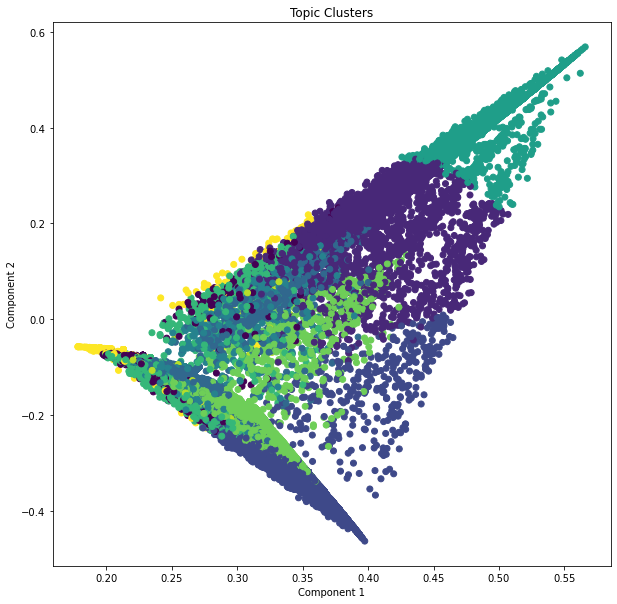

In [46]:
# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")

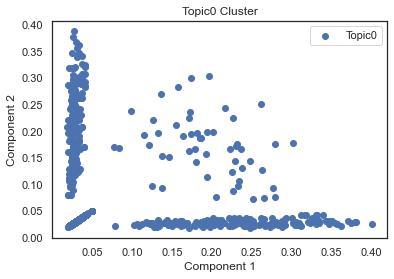

In [80]:
# Topic0 Cluster

filtered_label0 = lda_output[kmeans_clust == 0]
 
#plotting the results
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1], label = "Topic0")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic0 Cluster")
plt.legend();

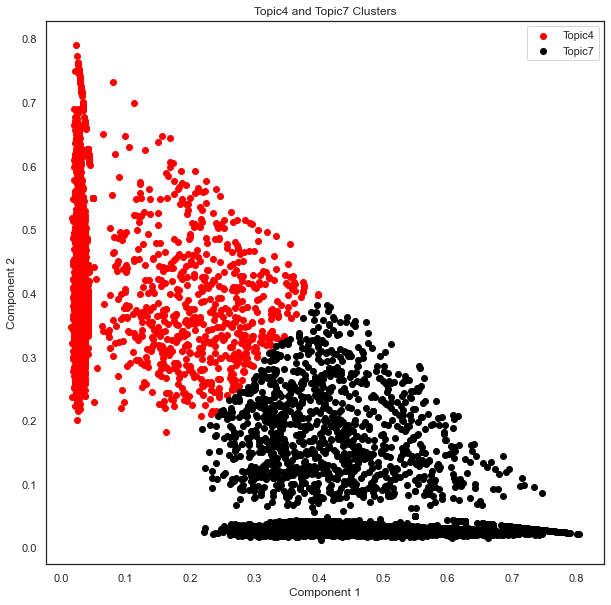

In [81]:
# Topic0 and Topic 7 Clusters
filtered_label1 = lda_output[kmeans_clust == 4]
 
filtered_label9 = lda_output[kmeans_clust == 7]
 
#Plotting the results
plt.figure(figsize=(10, 10))
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'red', label = "Topic4")
plt.scatter(filtered_label9[:,0] , filtered_label9[:,1] , color = 'black', label = "Topic7")
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic4 and Topic7 Clusters")
plt.legend();

### Find documents within a topic that are similar to a given document

In [50]:
# Using Euclidean distance

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus(text=text_example, doc_topic_probs=lda_output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

AID-WATER,FOOD,SHELTER,MEDICINE

 syed mazahir abbas mouza shahwali tehsil ali pur district muzaffar garh about housholds starvation no rescue team reached 



In [83]:
# Using Cosine Similarity

text_example = ["We need food and medical suppies. The kids also need blankets and clothing"]
infer_topic, topic, prob_scores = topic_prediction(text = text_doc)
#print(topic)
print(infer_topic)
doc_ids, docs = similar_corpus_cosine(text=text_example, doc_topic_probs=lda_output, documents = message_data, top_n=1, verbose=False)
print('\n', docs[0][:500])
print()

AID-WATER,FOOD,SHELTER,MEDICINE

 we have clothes for all ages and brand new shoes and boots we have baby items like diapers car seats high chair ect we also have hygine products like wipes toothbrushes toothpaste ect we also have some kids toys and stuffed animals even a bike and we also have some non perishable foods and blankets 



### Save items for FLASK app

In [85]:
# Save Model

with open('best_lda_model.pickle', 'wb') as to_write:
    pickle.dump(best_lda_model, to_write)
    
# Save nlp

with open('nlp.pickle', 'wb') as to_write:
    pickle.dump(nlp, to_write)

# Save Count Vectorizer
with open('vectorizer.pickle', 'wb') as to_write:
    pickle.dump(vectorizer, to_write)
    
# Save Count Vectorizer
with open('topic_keywords_df.pickle', 'wb') as to_write:
    pickle.dump(topic_keywords_df, to_write)    

### Plots

In [51]:
# Plot distributions
tmp_words = []
for i in range(len(message_words)):
    tmp_words.append(len(message_words[i]))

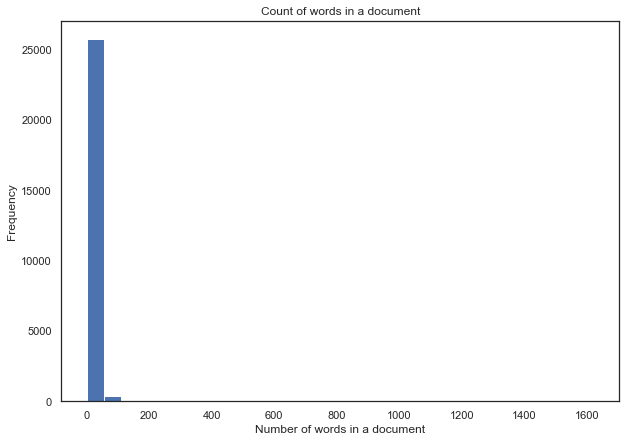

In [52]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(tmp_words,30);
ax.set_title('Count of words in a document')
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of words in a document');

In [53]:
# Plots number of documents in topic

topic_list = []
topic_count = []
tot_topic = len(Topics)
for i in range(tot_topic):
    topic_l = Topics[i]
    mask = document_topic_df['dominant_topic'] == i
    topic_c = len(document_topic_df[mask])
    topic_list.append(topic_l)
    topic_count.append(topic_c)

topic_count_dict = {'Topic': topic_list, 'Count': topic_count}
topic_count_df = pd.DataFrame(topic_count_dict)
topic_count_df2 = topic_count_df.sort_values('Count', ascending = False)

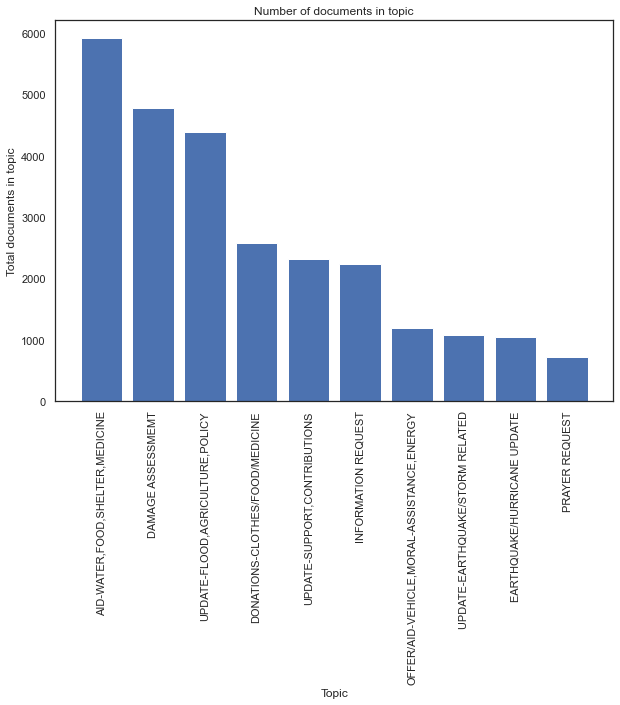

In [54]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])
x_index = np.arange(topic_count_df2.Topic.count())
ax.set_xticks(ticks=x_index)

ax.bar(x_index,topic_count_df2['Count']);
ax.set_title('Number of documents in topic')
ax.set_ylabel('Total documents in topic')
ax.set_xlabel('Topic');
ax.set_xticklabels(topic_count_df2['Topic'],rotation = 90, horizontalalignment = 'center' );

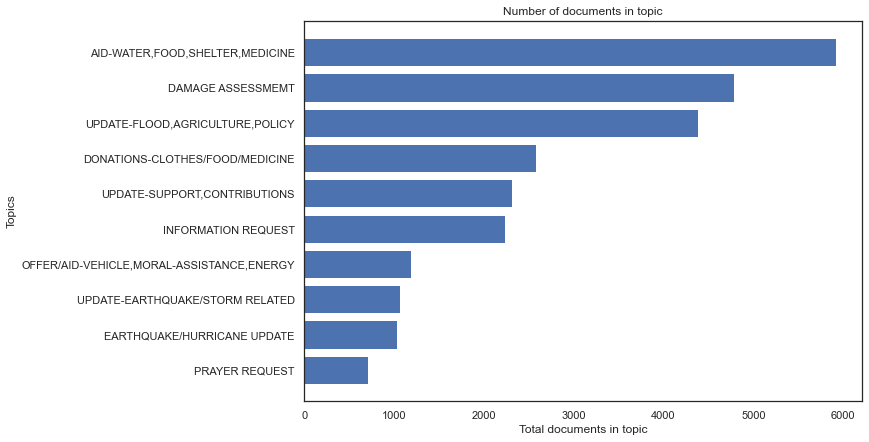

In [88]:
topic_count_df2 = topic_count_df.sort_values('Count', ascending = True)
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(topic_count_df2['Topic'].count())
plt.barh(y_pos, topic_count_df2['Count'])
plt.yticks(y_pos, topic_count_df2['Topic'])
plt.title('Number of documents in topic')
plt.ylabel('Topics')
plt.xlabel('Total documents in topic');

### Frequency of keywords in topic

In [55]:
def flatten(outer_list):
    '''
    Function to flatten a list of list
    '''
    return [item for sublist in outer_list for item in sublist]

In [56]:
# top keywords count for Topic 0

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 0
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 0']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

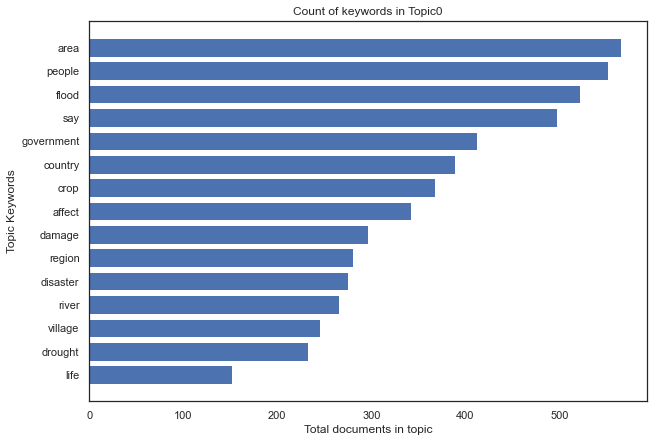

In [57]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic0')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [58]:
# top keywords count for Topic 4

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 4
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 4']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

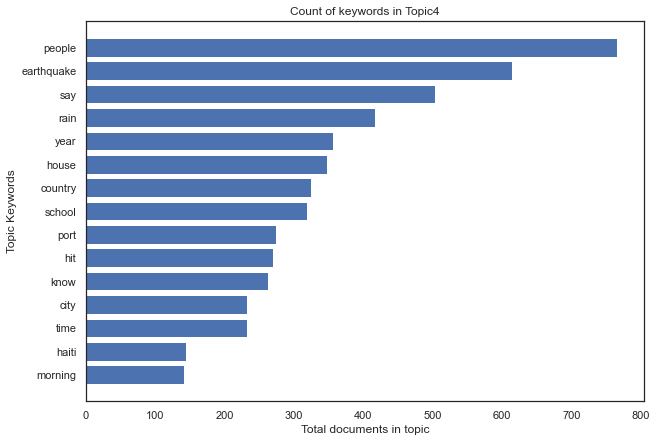

In [59]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic4')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');

In [60]:
# top keywords count for Topic 9

#print(df_keywords_topic.head())
top_keywords = []
top_keywords_count = []

mask = document_topic_df['dominant_topic'] == 9
topic_kw_df = document_topic_df[mask]

message_list = topic_kw_df['message']
message_list2 = list(tokenize_doc(message_list))
message_list3 = lemmatization(message_list2, allowed_postags=['NOUN', 'VERB'])
message_list4 = list(tokenize_doc(message_list3))
message_flat = flatten(message_list4)
message_count = Counter(message_flat)

for item in keywords_topic_df['Topic 9']:
    top_keywords.append(item)
    top_keywords_count.append(message_count[item])
    
keyword_count_dict = {'Keyword': top_keywords, 'Count': top_keywords_count}
keyword_count_df = pd.DataFrame(keyword_count_dict)
keyword_count_df2 = keyword_count_df.sort_values('Count', ascending = True)

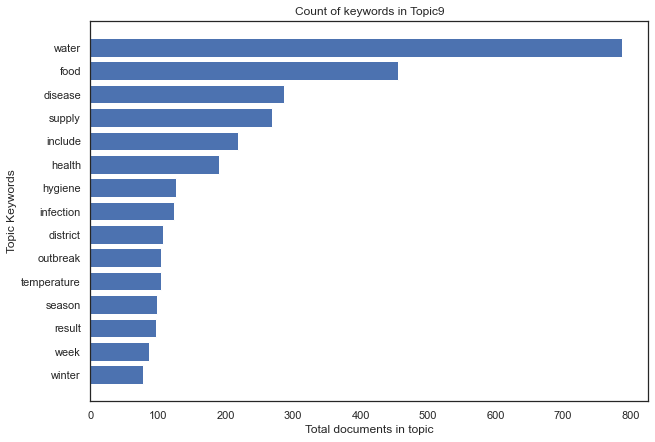

In [61]:
sns.set_theme(style='white')
fig, ax = plt.subplots(figsize=[10,7])

y_pos = np.arange(keyword_count_df2['Keyword'].count())
plt.barh(y_pos, keyword_count_df2['Count'])
plt.yticks(y_pos, keyword_count_df2['Keyword'])
plt.title('Count of keywords in Topic9')
plt.ylabel('Topic Keywords')
plt.xlabel('Total documents in topic');